In [64]:
# import required modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
BASE_PATH = '/content/drive/MyDrive/hot-dog/input/train/'

In [92]:
IMAGE_SIZE = (256, 256)

In [93]:
# Reading data from directory
training_ds = tf.keras.utils.image_dataset_from_directory(
  BASE_PATH,
  validation_split=0.3,
  subset="training",
  seed=99,
  image_size=IMAGE_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  BASE_PATH,
  validation_split=0.3,
  subset="validation",
  seed=99,
  image_size=IMAGE_SIZE
)



Found 498 files belonging to 2 classes.
Using 349 files for training.
Found 498 files belonging to 2 classes.
Using 149 files for validation.


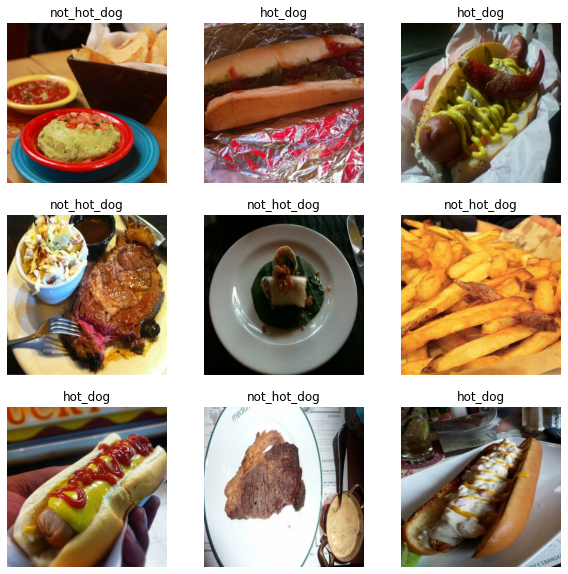

In [94]:
# Seeing some of the images

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(training_ds.class_names[labels[i]])
        plt.axis("off")

In [95]:
# Normalizing Data

normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = training_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [96]:
# Configuring the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [97]:
input_shape = (IMAGE_SIZE + (3,))

In [98]:
base_model_resnet50 = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', include_top = False, input_shape = input_shape)
base_model_resnet50.trainable = False

In [99]:
# Model creation
NUM_CLASSES = 2

In [108]:
inputs = tf.keras.Input(shape=input_shape, name='image')
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model_resnet50(x)
x = layers.Rescaling(1./255)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(NUM_CLASSES)(x)
model = tf.keras.Model(inputs, outputs, name='resnet50')

In [109]:
# Compiling Model
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [110]:
# Training data
history = model.fit(
  training_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
11/11 [==============================] - 5s 259ms/step - loss: 0.6860 - accuracy: 0.6476 - val_loss: 0.6753 - val_accuracy: 0.8389
Epoch 2/20
11/11 [==============================] - 2s 171ms/step - loss: 0.6639 - accuracy: 0.8367 - val_loss: 0.6488 - val_accuracy: 0.8725
Epoch 3/20
11/11 [==============================] - 2s 172ms/step - loss: 0.6340 - accuracy: 0.8854 - val_loss: 0.6152 - val_accuracy: 0.8725
Epoch 4/20
11/11 [==============================] - 2s 173ms/step - loss: 0.5980 - accuracy: 0.8825 - val_loss: 0.5768 - val_accuracy: 0.8792
Epoch 5/20
11/11 [==============================] - 2s 172ms/step - loss: 0.5572 - accuracy: 0.9026 - val_loss: 0.5341 - val_accuracy: 0.8993
Epoch 6/20
11/11 [==============================] - 2s 172ms/step - loss: 0.5109 - accuracy: 0.9026 - val_loss: 0.4906 - val_accuracy: 0.8926
Epoch 7/20
11/11 [==============================] - 2s 172ms/step - loss: 0.4658 - accuracy: 0.8968 - val_loss: 0.4491 - val_accuracy: 0.8926
Epoch 

In [111]:
model.save_weights('/content/weights.h5')
model.save('/content/model.h5')

In [112]:
TEST_PATH = '/content/drive/MyDrive/hot-dog/input/test/'

In [113]:
testing_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_PATH,
  subset=None,
  validation_split=None,
  seed=99,
  image_size=IMAGE_SIZE
)

Found 500 files belonging to 2 classes.


In [114]:
model.evaluate(testing_ds)

16/16 [==============================] - 4s 177ms/step - loss: 0.2556 - accuracy: 0.9100


[0.25556159019470215, 0.9100000262260437]